## Default

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.9.1
1.23.1
3.5.2
0.6.0


[Naver 영화리뷰 감정 분석 Task](https://github.com/e9t/nsmc/)

한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요?
KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

(여러분들은 fasttext(https://wikidocs.net/22883)로
사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는
형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다.


기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

<img src="./img/evaluation.png">

In [2]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [3]:
import os 
path_to_file = './data/korean-english-park.train.ko'

with open(path_to_file, 'r') as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

Data Size: 94123


## Naver Movie Review

In [4]:
import requests

url = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt'

with open('./data/ratings.txt', "wb") as file:
    res = requests.get(url)
    file.write(res.content)

In [5]:
import pandas as pd

df = pd.read_table('./data/ratings.txt', encoding='utf-8')
df = df.dropna(how='any')
df = df.drop_duplicates(['document'])

train = pd.read_table('./data/ratings_train.txt')
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
test = pd.read_table('./data/ratings_test.txt')
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
f'total: {len(df)}'

'total: 194543'

In [8]:
train = train.dropna(how='any')
train = train.drop_duplicates(['document'])
# test = test.dropna(how='any')
# test = test.drop_duplicates(['document'])

X_train = train['document'].values
y_train = train['label'].values
X_test = test['document'].values
y_test = test['label'].values

In [9]:
X_train

array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
       '너무재밓었다그래서보는것을추천한다', ..., '이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?',
       '청춘 영화의 최고봉.방황과 우울했던 날들의 자화상', '한국 영화 최초로 수간하는 내용이 담긴 영화'],
      dtype=object)

In [10]:
print(len(X_train), np.bincount(y_train))

146182 [73342 72840]


In [11]:
print(len(X_test), np.bincount(y_test))

50000 [24827 25173]


### Processing

In [12]:
df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [13]:
# 결측치 8개 제거

df = df.dropna(how='any')

df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [14]:
f'total: {len(df)}'

'total: 194543'

In [15]:
df = df.drop_duplicates(['document'])

In [16]:
f'total: {len(df)}'


# 중복값 5449개 제거

'total: 194543'

### Vis

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def show_distribution(_df, key):
    total = list(map(lambda it: len(it), _df[key]))

    print(f'최대: {np.max(total)}')
    print(f'최소: {np.min(total)}')
    print(f'평균: {np.mean(total)}')

    plt.figure(figsize = (12,5))
    plt.hist(total, bins=50, alpha=0.5, color="b")
    plt.xlabel('length of sample')
    plt.ylabel('number of sample')
    plt.show()

최대: 142
최소: 1
평균: 36.0423453940774


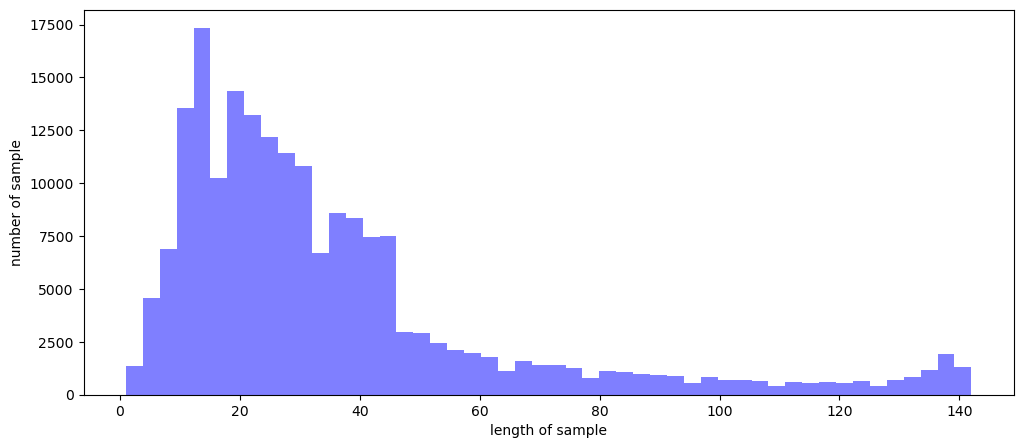

In [18]:
show_distribution(df, 'document')

In [19]:
## Max_len 찾기

def below_threshold_len(_df, key, max_len):
    total = df[key]
    _list = list(filter(lambda it: len(it) <= max_len, total))
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {len(_list)/len(total)}')

In [20]:

for _len in list(range(0, 140, 10)):
    below_threshold_len(df, 'document', _len)

전체 샘플 중 길이가 0 이하인 샘플의 비율: 0.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.0834057252124209
전체 샘플 중 길이가 20 이하인 샘플의 비율: 0.35149555625234524
전체 샘플 중 길이가 30 이하인 샘플의 비율: 0.5596706126666084
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.717933824398719
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.8205640912291884
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.8586739178484962
전체 샘플 중 길이가 70 이하인 샘플의 비율: 0.8866523082300571
전체 샘플 중 길이가 80 이하인 샘플의 비율: 0.9084726769917191
전체 샘플 중 길이가 90 이하인 샘플의 비율: 0.9264995399474666
전체 샘플 중 길이가 100 이하인 샘플의 비율: 0.9405529882853663
전체 샘플 중 길이가 110 이하인 샘플의 비율: 0.9519849082208046
전체 샘플 중 길이가 120 이하인 샘플의 비율: 0.9620289601784695
전체 샘플 중 길이가 130 이하인 샘플의 비율: 0.9730239587134978


In [21]:
df = df[df['document'].apply(lambda it: len(it) >= 10)]
df = df[df['document'].apply(lambda it: len(it) <= 80)]

최대: 80
최소: 10
평균: 30.02943437671609


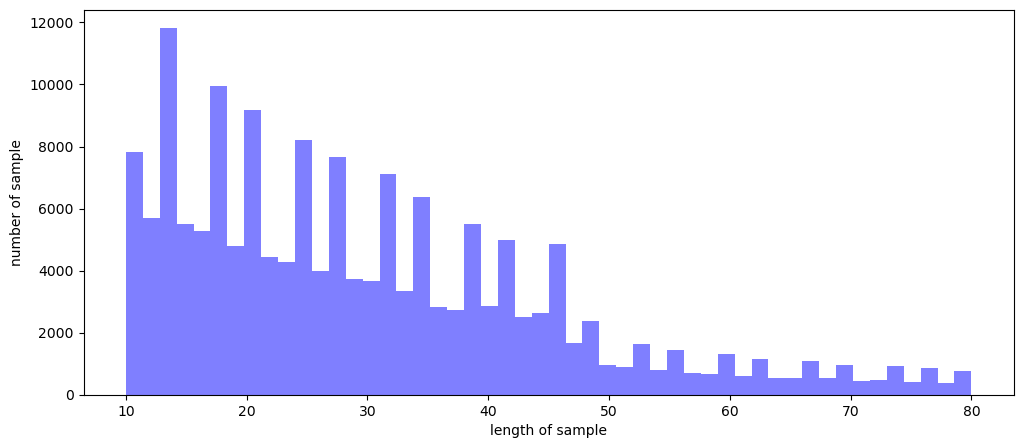

In [22]:
show_distribution(df, 'document')

## SentencePiece

In [23]:
models = {}

for model_type in ['unigram', 'bpe', 'char', 'word']:
    for vocab_size in [2000, 4000, 6000, 8000, 10000]:
        
        model_prefix = f'{model_type}_{str(vocab_size // 1000) + "k"}'
        models[model_prefix] = {}
        
        models[model_prefix]['model_type'] = model_type
        models[model_prefix]['vocab_size'] = vocab_size

models

{'unigram_2k': {'model_type': 'unigram', 'vocab_size': 2000},
 'unigram_4k': {'model_type': 'unigram', 'vocab_size': 4000},
 'unigram_6k': {'model_type': 'unigram', 'vocab_size': 6000},
 'unigram_8k': {'model_type': 'unigram', 'vocab_size': 8000},
 'unigram_10k': {'model_type': 'unigram', 'vocab_size': 10000},
 'bpe_2k': {'model_type': 'bpe', 'vocab_size': 2000},
 'bpe_4k': {'model_type': 'bpe', 'vocab_size': 4000},
 'bpe_6k': {'model_type': 'bpe', 'vocab_size': 6000},
 'bpe_8k': {'model_type': 'bpe', 'vocab_size': 8000},
 'bpe_10k': {'model_type': 'bpe', 'vocab_size': 10000},
 'char_2k': {'model_type': 'char', 'vocab_size': 2000},
 'char_4k': {'model_type': 'char', 'vocab_size': 4000},
 'char_6k': {'model_type': 'char', 'vocab_size': 6000},
 'char_8k': {'model_type': 'char', 'vocab_size': 8000},
 'char_10k': {'model_type': 'char', 'vocab_size': 10000},
 'word_2k': {'model_type': 'word', 'vocab_size': 2000},
 'word_4k': {'model_type': 'word', 'vocab_size': 4000},
 'word_6k': {'model_ty

In [24]:
import sentencepiece as spm

def TrainSentencePiece(model_prefix, model_type='unigram', vocab_size = 8000):
    spm.SentencePieceTrainer.Train(
        '--input={} --model_prefix={} --model_type={} --vocab_size={}'.format(
            temp_file, model_prefix, model_type, vocab_size)    
    ) 
    return tensor, word_index, index_word

In [25]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

def sp_tokenize(s, corpus):
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
    
    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [30]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def Text_ClassifierModel(model_prefix):
    tensor, word_index, index_word = sp_tokenize(s, df['document'])
    x_train, x_val, y_train, y_val = train_test_split(tensor, df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    # 6 : 2 : 2
    # trian : val : test

    word_vector_dim = 32

    model = Sequential()
    model.add(Embedding(vocab_size, word_vector_dim))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    epochs=20
    batch_size=64

    history = model.fit(
        x_train, y_train, epochs=epochs, batch_size=batch_size,
        validation_data=(x_val,y_val), callbacks=es, verbose=1)

    
Text_ClassifierModel(model_prefix)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1639/1639 [==============================] - 64s 38ms/step - loss: 0.6928 - accuracy: 0.5050 - val_loss: 0.6934 - val_accuracy: 0.4967
Epoch 2/20
1639/1639 [==============================] - 69s 42ms/step - loss: 0.6876 - accuracy: 0.5158 - val_loss: 0.6933 - val_accuracy: 0.4967
Epoch 3/20
1639/1639

In [31]:
result_spm = model.evaluate(x_test, y_test, verbose=0)

NameError: name 'model' is not defined

In [ ]:
result_spm

## koNLPy

In [32]:
from konlpy.tag import Okt

okt = Okt()
print(X_train[4])
print(okt.morphs(X_train[4]))

사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
['사이', '몬페', '그', '의', '익살스런', '연기', '가', '돋보였던', '영화', '!', '스파이더맨', '에서', '늙어', '보이기만', '했던', '커스틴', '던스트', '가', '너무나도', '이뻐', '보였다']


In [33]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def data_load(num_words=10000):
    
    x_train, x_val, y_train, y_val = train_test_split(df['document'], df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

In [34]:
x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()

In [35]:
index_to_word = { index: word for word, index in word_to_index.items() }

In [36]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

x_train.shape, x_test.shape, x_val.shape

((104889, 70), (26223, 70), (32778, 70))

In [37]:
y_train.shape, y_test.shape, y_val.shape

((104889,), (26223,), (32778,))

In [38]:
vocab_size = len(word_to_index)
word_vector_dim = 128

In [39]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         1280000   
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [40]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

epochs=20
batch_size=64

history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=es, verbose=1)

Epoch 1/20
1639/1639 [==============================] - 93s 56ms/step - loss: 0.3767 - accuracy: 0.8291 - val_loss: 0.3429 - val_accuracy: 0.8506
Epoch 2/20
1639/1639 [==============================] - 92s 56ms/step - loss: 0.2896 - accuracy: 0.8764 - val_loss: 0.3219 - val_accuracy: 0.8591
Epoch 3/20
1639/1639 [==============================] - 99s 60ms/step - loss: 0.2444 - accuracy: 0.8973 - val_loss: 0.3334 - val_accuracy: 0.8577
Epoch 4/20
1639/1639 [==============================] - 98s 60ms/step - loss: 0.2073 - accuracy: 0.9149 - val_loss: 0.3491 - val_accuracy: 0.8543
Epoch 5/20
1639/1639 [==============================] - 98s 60ms/step - loss: 0.1704 - accuracy: 0.9317 - val_loss: 0.4205 - val_accuracy: 0.8495
Epoch 6/20
1639/1639 [==============================] - 98s 60ms/step - loss: 0.1376 - accuracy: 0.9463 - val_loss: 0.4765 - val_accuracy: 0.8471
Epoch 6: early stopping


In [41]:
result_mecab = model.evaluate(x_test, y_test, verbose=1)

820/820 [==============================] - 8s 9ms/step - loss: 0.4630 - accuracy: 0.8510


In [42]:
result_mecab

[0.4629574716091156, 0.8509705066680908]